# Cell-cell communication with LIANA
This notebook outlines the steps of inference, analysis and visualization of cell-cell communication for a single-cell RNA sequencing data using **LIANA**. 

For comprehensive instructions and detailed descriptions of the methods, please refer to the official [DOCUMENTATION](https://liana-py.readthedocs.io/en/latest/index.html).

The source code is available on GitHub: [saezlab/liana-py](https://github.com/saezlab/liana-py).

## About LIANA
LIANA (LIgand-receptor ANalysis frAmework) is a flexible and extensible toolkit designed to infer ligand–receptor interactions from single-cell transcriptomics data using prior biological knowledge. It serves as a unified framework that harmonizes and integrates multiple existing methods and databases to study cell–cell communication in a robust and reproducible way.

LIANA allows users to combine various inference methods and ligand–receptor resources, or to generate consensus results across them. It supports both Python and R, with the Python implementation offering faster performance, better memory efficiency, and active feature development. The R version remains available and is suitable for users working within R-based workflows.

This notebook demonstrates how to apply LIANA to analyze cell–cell communication, highlighting its modularity, interpretability, and support for consensus-based analyses.

## Load the required libraries

In [1]:
import liana as li
import scanpy as sc
import anndata

## Data input 
Liana requires
- **gene expression data**:  processed single-cell transcriptomics data as anndata object with pre-defined cell labels (identities).
- **ligand-receptor database**: a reference file containing all putative ligand–receptor pairs used for inference.

### Gene expression data
Liana use anndata objects with processed single-cell transcriptomics data, with pre-defined cell labels (identities)

In [2]:
# inspect data
adata = anndata.read_h5ad("../../../../data_vt3/first/2306scRNAseq_HMI_Ischemic.h5ad")

### Ligand-Receptor Interactions
 LIANA+ provides a frozen set of interactions across resources. These are accessible through the select_resource function in the resource module. The resources that are currently supported are:

In [3]:
li.resource.show_resources()

['baccin2019',
 'cellcall',
 'cellchatdb',
 'cellinker',
 'cellphonedb',
 'celltalkdb',
 'connectomedb2020',
 'consensus',
 'embrace',
 'guide2pharma',
 'hpmr',
 'icellnet',
 'italk',
 'kirouac2010',
 'lrdb',
 'mouseconsensus',
 'ramilowski2015']

By default, liana uses the consensus resource, which is composed by multiple expert-curated ligand-receptor resources, including CellPhoneDB, CellChat, ICELLNET, connectomeDB2020, and CellTalkDB.
All of the ligand-receptor resource in LIANA+ were pre-generated using the OmniPath meta-database. Though any custom resource can also be passed, including those provided by the user or generated using the omnipath client package.

In [4]:
resource = li.rs.select_resource('consensus')
resource.head()

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
3,LGALS9,LRP1
4,LGALS9,CD47


## Inference of cell-cell communication
LIANA re-implemetns multiple methods to infer cell-cell communication based on ligand-receptor interactions. Each tool relies on different biological assumptions and scoring strategies, typically providing two key scores per interaction:
- Magnitude score: Captures the strength or intensity of the interaction (often based on gene expression).
- Specificity score: Measures how uniquely the interaction occurs between specific cell type pairs, often derived from statistical significance or contrast with background.

The tools implemented in this repository are:
- CellPhoneDBv2: 
    - Magnitude: Mean expression of ligand and receptor in their respective sender and receiver cell types.
    - Specificity: One-sided permutation test: cell type labels are shuffled to generate a null distribution, and an empirical p-value is computed by comparing the observed magnitude score to this null.
- Connectome
    - Magnitude: Product of the mean expression of ligand and receptor in their respective sender and receiver cell types.
    - Specificity: Average of the z-scores for ligand and receptor expression, indicating how much each is upregulated in the respective cell type relative to others.
-log2FC(iTALK-inspired):
    - Magnitude: /
    - Specificity: Average of one-vs-rest log2 fold-change (log2FC) values for ligand (in the sender cell type) and receptor (in the receiver cell type), highlighting interactions with cell-type-specific expression.
- NATMI
    - Magnitude: Product of the mean expression of ligand and receptor in their respective sender and receiver cell types.
    - Specificity: Product of: (1) Ligand mean expression in the sender divided by its total expression across all cell types, and (2) Receptor mean expression in the receiver divided by its total expression across all cell types.
- SingleCellSignalR: 
    - Magnitude: Geometric mean of the mean expression of ligand and receptor in sender and receiver cell types, regularized by the mean expression across the entire dataset.
    - Specificity: /
- Geometric mean: 
    - Magnitude: Geometric mean of the mean expression of ligand and receptor in sender and receiver cell types.
    - Specificity: One-sided permutation test: cell type labels are shuffled to generate a null distribution, and an empirical p-value is computed by comparing the observed magnitude score to this null.
- scSeqComm:
    - Magnitude: Minimum of the cumulative distribution functions (CDFs) of ligand and receptor expression, where expression is modeled as a normal distribution with: Mean = gene's mean expression in the cell type
    Std = gene's standard deviation divided by √(number of cells)
    - Specificity: /
- CellChat: 
    - Magnitude: Hill function applied to the product of Tukey’s trimean expression of ligand and receptor in sender and receiver cell types. The original CellChat implementation additionally uses information about mediator proteins, which is not implemented here.
    - Specificity: One-sided permutation test: cell type labels are shuffled to generate a null distribution, and an empirical p-value is computed by comparing the observed magnitude score to this null.


 > All methods are implemented as instances of the Method class. To obtain further information for each method the user can refer to the methods documentation ?method_name

 > Some differences are expected with the original implementations largely due to different preprocessing steps which LIANA+ harmonised across the different methods. Specifically, 
 - LIANA+ considers the minimum score (e.g. average expression) for complex subunits, while some methods consider the mean, geometric mean, or simply do not account for complexes at all.
 - LIANA considers interactions as occurring only if both the ligand and receptor, as well as all of their subunits, are expressed above a certain proportion of cells in both clusters involved in the interaction (0.1 by default).
 Please consider citing the original methods when using their LIANA+ adaptations in your work!

In [5]:
li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...
0,scSeqComm,inter_score,None,"Baruzzo, G., Cesaro, G., Di Camillo, B. 2022. ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."


### LIANA consensus score
LIANA also provides a consensus score that integrates the predictions from multiple individual methods. To unify and compare these heterogeneous outputs, LIANA implements a robust consensus strategy using the RobustRankAggregate (RRA) algorithm:

- Rank and Normalize Scores: For each interaction and each method, magnitude and specificity scores are ranked independently. These ranks are then normalized to a [0,1] scale by dividing each rank by the maximum possible rank for that method.
- Compare Against Null Model: Each normalized rank is evaluated against a null model of random rankings using a beta distribution. This yields a p-value representing the likelihood of observing that rank by chance. The minimum p-value across all methods is retained for each interaction, capturing the strongest consensus signal.

LIANA performs consensus scoring across the following tools: CellPhoneDB, Connectome, log2FC (iTALK-inspired), NATMI and SingleCellSignalR

In [6]:
from liana.mt import rank_aggregate


li.mt.rank_aggregate(adata,                                 # Annotated data object
                    groupby='cell_type',                    # Column in `adata.obs` indicating cell type or identity.
                    use_raw=False,                          # Use `adata.raw` for gene expression if available. Set to False to use `adata.X`.
                    resource_name='consensus',              # Name of the resource to be used for ligand-receptor inference.
                    
                    # Method parameters
                    expr_prop=0.1,                          # Minimum expression proportion for the ligands and receptors in the corresponding cell identities. 
                    min_cells = 5,                          # Minimum cells (per cell identity) to be considered for downstream analysis.
                    n_perms=1000,                           # Number of permutations for the permutation test. Relevant only for permutation-based methods
                    n_jobs=1,                               # Number of parallel processes. Increase to speed up computation.

                    # Aggregation
                    aggregate_method = 'rra',              # Aggregation strategy: 
                                                           # - 'mean': average rank across methods
                                                           # - 'rra': Robust Rank Aggregation, provides p-values for consensus ranks
                    consensus_opts= None,                  # Which scores to aggregate across methods. If None, uses both 'Magnitude' and 'Specificity'.

                    verbose=True)                          # Print progress during execution.

Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
/project/.pixi/envs/default/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
6925 features of mat are empty, they will be removed.
/project/.pixi/envs/default/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/project/.pixi/envs/default/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.29 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 14961 samples and 1241 features


/project/.pixi/envs/default/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
/project/.pixi/envs/default/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:262: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:10<00:00, 98.66it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


LIANA allows you to compute custom consensus rankings by selecting a subset of methods.

In [7]:
from liana.mt import logfc, geometric_mean, cellphonedb
from liana.mt import AggregateClass, aggregate_meta

# Select only a subset of methods
methods = [logfc, geometric_mean, cellphonedb]

# Instantiate a new AggregateClass with the chosen methods
new_rank_aggregate = AggregateClass(aggregate_meta, methods=methods)

# Run the aggregation (in-place on `adata`)
new_rank_aggregate(adata,                                 # Annotated data object
                   groupby='cell_type',                    # Column in `adata.obs` indicating cell type or identity.
                   use_raw=False,                          # Use `adata.raw` for gene expression if available. Set to False to use `adata.X`.
                   resource_name='consensus',              # Name of the resource to be used for ligand-receptor inference.
    
                   # Method parameters
                   expr_prop=0.1,                          # Minimum expression proportion for the ligands and receptors in the corresponding cell identities. 
                   verbose=True)                          # Print progress during execution.



Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
/project/.pixi/envs/default/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
6925 features of mat are empty, they will be removed.
/project/.pixi/envs/default/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/project/.pixi/envs/default/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.29 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 14961 samples and 1241 features
Assuming that counts were `natural` log-normalized!


/project/.pixi/envs/default/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:272: ImplicitModificationWarning: Setting element `.layers['normcounts']` of view, initializing view as actual.


Running log2FC
Running Geometric Mean


100%|██████████| 1000/1000 [00:12<00:00, 80.65it/s]


Running CellPhoneDB


100%|██████████| 1000/1000 [00:12<00:00, 78.82it/s]


## Description of output files
By default, LIANA modifies the AnnData object in place, and stores the results under: adata.uns['liana_res']. This DataFrame contains the consensus interaction scores across all selected methods.
Specifically, it includes:
- source: Sender cell type (the cell expressing the ligand).
- target: Receiver cell type (the cell expressing the receptor).
- ligand_complex: Ligand name (subunits separated by _ if it’s a complex).
- receptor_complex: Receptor name (similarly structured).
- Method-specific scores: Columns with scores returned by individual methods (e.g., CellPhoneDBv2, Connectome, NATMI).
    → Use li.mt.show_methods() to see which columns correspond to which method.
- magnitude_rank: Robust consensus ranking of interaction strength across methods. Lower values indicate stronger and more consistent interactions.
- specificity_rank: Robust consensus ranking of interaction specificity across methods.

In [8]:
adata.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_logfc,lr_gmeans,gmean_pvals,lr_means,cellphone_pvals,specificity_rank,magnitude_rank
3011,CM,CM,NCAM1,CACNA1C,1.358989,1.642995,0.0,1.764854,0.0,0.006844,2.059495e-08
9270,Fib,PC,COL1A2,CD36,1.433035,1.579941,0.0,1.607456,0.0,0.003652,2.522882e-07
7328,Fib,Adipo,COL1A2,CD36,1.231196,1.513283,0.0,1.553298,0.0,0.013240,3.295193e-07
7657,Fib,CM,COL1A2,CD36,1.129311,1.459053,0.0,1.510960,0.0,0.013240,4.170478e-07
4983,CM,vSMCs,NCAM1,CACNA1C,0.979769,1.451278,0.0,1.500124,0.0,0.013240,5.148738e-07


## Basic analysis and plotting
LIANA provides built-in visualization tools to help explore and present cell–cell communication results. The plots are built using plotnine (a Python implementation of ggplot2), so they are highly customizable. To customize further (e.g., change fonts, labels, themes), you can assign the plot to a variable and modify it using plotnine syntax.


**Dotplot of relevant interactions**: The dotplot is one of the key visualizations. It displays ligand–receptor pairs as dots. 
We’ll now plot the top-ranked interactions based on magnitude_rank from the aggregated consensus.

/project/.pixi/envs/default/lib/python3.10/site-packages/liana/plotting/_common.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


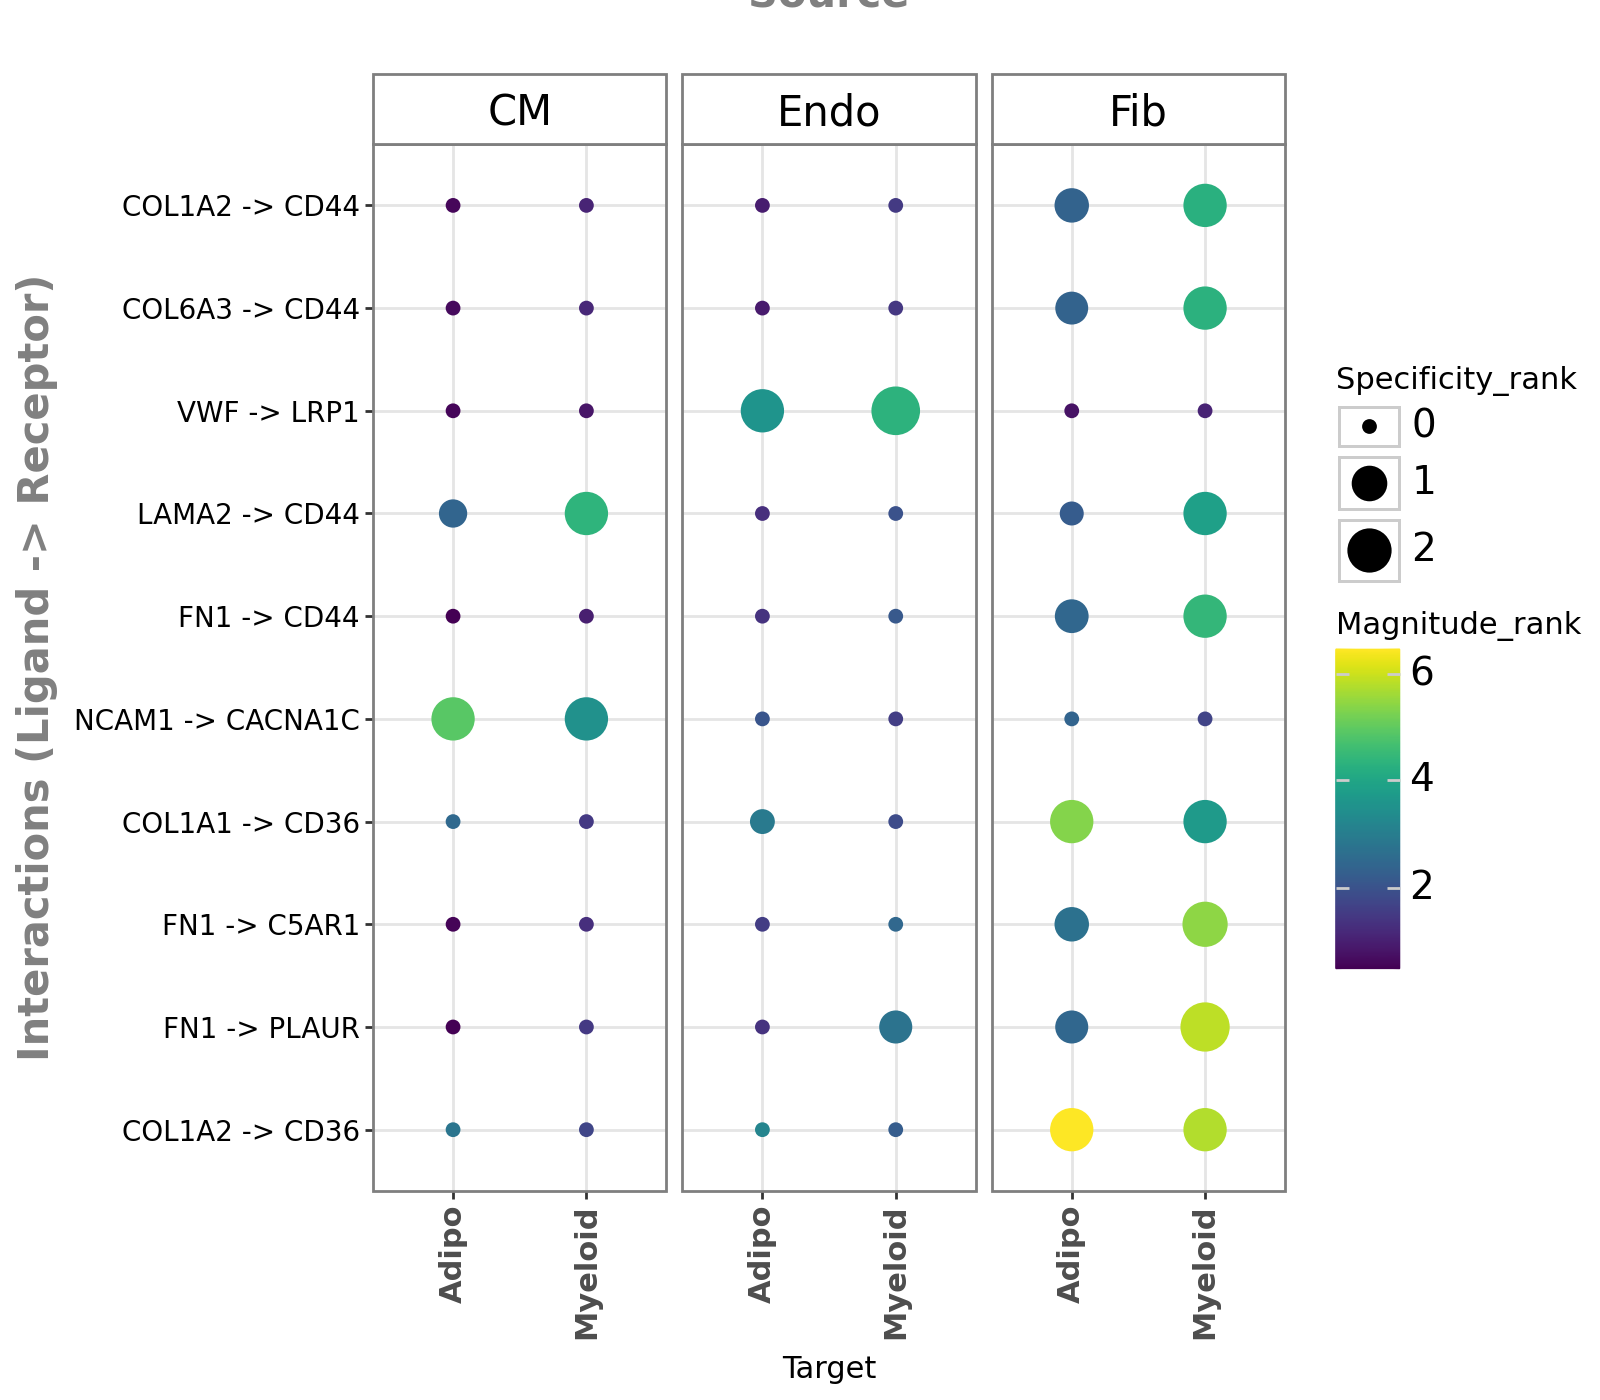

In [9]:
li.pl.dotplot(adata = adata,                                                    # Annotated data object with LIANA results.
              uns_key='liana_res',                                              # Key where LIANA results are stored in `adata.uns`.
              colour='magnitude_rank',                                          # Dot color reflects interaction strength (magnitude).
              size='specificity_rank',                                          # Dot size reflects interaction specificity.


              # Filter interactions
              source_labels=['CM', 'Fib', 'Endo'],                              # List of labels to use as `source`, the rest are filtered out.
              target_labels=['Myeloid', 'Adipo'],                               # List of labels to use as `target`, the rest are filtered out.
              ligand_complex = None,                                            # List of ligand complexes to filter the interactions to be plotted. 
              #receptor_complex = ['CD44'],                                     # List of receptor complexes to filter the interactions to be plotted.
              top_n=10,                                                         # Show top 10 interactions based on `orderby` column.
              orderby='magnitude_rank',                                         # specify how to order the interactions
              orderby_ascending=True,                                           # specify how to order the interactions

              # Visualization parameters
              inverse_size=True,                                                # Whether to -log10 transform the size column for plotting. 
              inverse_colour=True,                                              # Whether to -log10 transform the colour column for plotting. 
              figure_size=(8, 7)                                                # Figure size
             )

# Unexplored feature
- **Cross-condition analysis**:
LIANA+ supports comparative analysis of cell–cell communication across experimental conditions or sample groups through:
    - Differential CCC analysis (hypothesis-driven): Leverages statistical frameworks like PyDESeq2 to identify significantly deregulated ligand–receptor interactions between conditions.
    - Unsupervised discovery (hypothesis-free): Uses non-negative matrix factorization (NMF) or higher-order tensor factorizations (via Tensor-cell2cell) to uncover shared and condition-specific communication patterns across multiple samples.

- **Intracellular signaling**
LLIANA+ connects intercellular interactions to intracellular signalling pathways using sign-coherent network optimization. In particular, LIANA+ select the potentially deregulated ligand-receptor interactions (input nodes) and deregulated TFs (output nodes). Use CORNETO to identify a solution in the form of a causal (smallest sign-consistent signaling) network that explains the measured inputs and outputs

- **Spatially-resolved data**
LIANA+ incorporates spatial context in CCC analysis using:
    - Multi-view learning frameworks to capture global (long-range tissue-level) communication patterns 
    - Local spatial metrics to capture local (neighboring cells) communication patterns 

- **Multi-modal single-cell ans spatially-resolved technlogies**
LIANA+ is applicable to both dissociated single-cell and spatially resolved multi-omics data.


# Citation


- **LIANA**: *Comparison of methods and resources for cell-cell communication inference from single-cell RNA-Seq data. Dimitrov D, et al., Nat Commun. 2022*
- **LIANA+**: *LIANA+ provides an all-in-one framework for cell–cell communication inference. Dimitrov D., et al. Nat Cell Biol. 2024*